# Implementation

- We will implement a random forest model on the Titanic survival data. Since the moel with Perceptron only achieved around 73% accuracy, I want to see if we can do better with a more sophisticated random forest model. One area of improvement is the ability to include more attributes, which will hopefully improve the model's accuracy.

# 1 - Importing necessary libraries and dataset

- we will use the same Titanic data as was used for Perceptron

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Load the dataset
df = pd.read_csv("../../data/Titanic-Dataset.csv")

# 2 - Initial screening and data clensing

- we will look for missing values in the dataset and drop any columns with significant numbers of missing values

In [6]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

** Remarks **

Looks like there are a lot of missing values in Cabin, Age, and 2 in Embarked.

- We will also drop Name, Passenger ID, and Ticket as its irrelevant to our survival analysis

In [14]:
# Drop Cabin (too many missing), Name and Ticket (not immediately useful)
titanic_cleaned = df.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'])   

# Also drop rows with missing values in the remaining columns
titanic_cleaned = titanic_cleaned.dropna()

# Double-check the cleaned DataFrame
print(titanic_cleaned.info())


<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  712 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB
None


# 2 - Initial visualization

/var/folders/y5/q7gh66fx2t58smbbcwxps5h40000gn/T/ipykernel_7015/3198714534.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Survived", palette="pastel", legend=False)


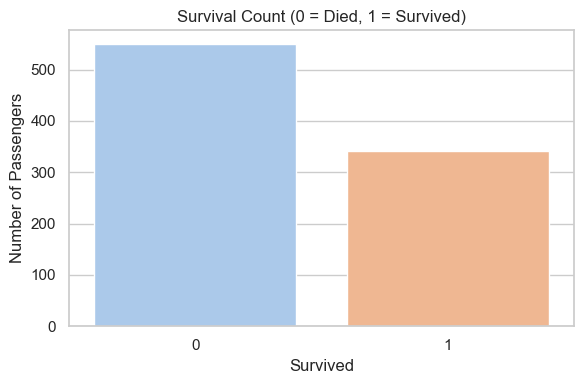

/var/folders/y5/q7gh66fx2t58smbbcwxps5h40000gn/T/ipykernel_7015/3198714534.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Survived", loc="upper right")


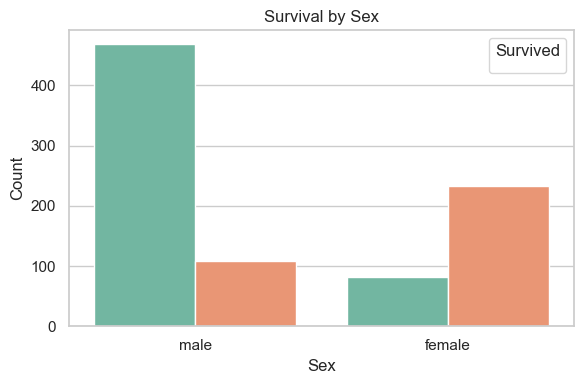

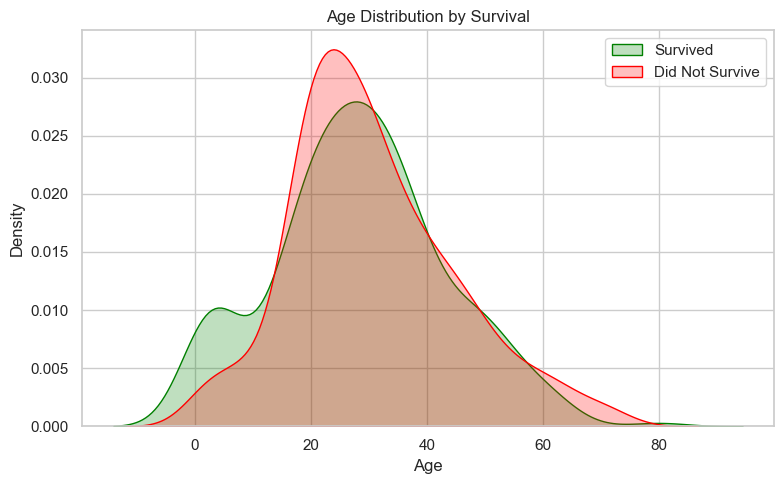

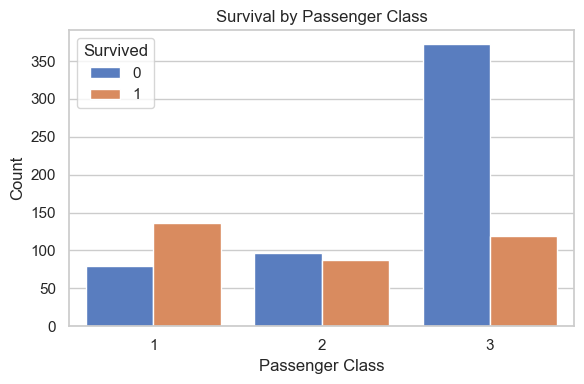

In [8]:
# Set Seaborn style
sns.set(style="whitegrid")

# Plot 1: Survival Count
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Survived", palette="pastel", legend=False)
plt.title("Survival Count (0 = Died, 1 = Survived)")
plt.xlabel("Survived")
plt.ylabel("Number of Passengers")
plt.tight_layout()
plt.show()

# Plot 2: Survival by Sex
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Sex", hue="Survived", palette="Set2",legend=False)
plt.title("Survival by Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Survived", loc="upper right")
plt.tight_layout()
plt.show()

# Plot 3: Age Distribution by Survival
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df[df["Survived"] == 1], x="Age", label="Survived", fill=True, color="green")
sns.kdeplot(data=df[df["Survived"] == 0], x="Age", label="Did Not Survive", fill=True, color="red")
plt.title("Age Distribution by Survival")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 4: Class vs Survival
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Pclass", hue="Survived", palette="muted")
plt.title("Survival by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.legend(title="Survived")
plt.tight_layout()
plt.show()


** Remarks **

- as with when we used this dataset for Perceptrons, the attributes differs greatly in their distinguishbility with regards to survival. However, since the random forest model can actually help us calculate the exact feature importance, we don't need to prescreen and can proceed to training the model directly.

# 3 - Train random forest model 

- we will split the data into testing and train, and train a random forest model.

In [18]:
# Drop PassengerId
X = titanic_cleaned.drop(columns=['Survived'])
y = titanic_cleaned['Survived']


# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Fit Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# 4 - Visualize the structure of the random forest

- while we can't print out the random forest model since there are too many trees, we can get a glimpse by printing out the depth and leaves of say 10 of its trees.

In [24]:
for i, tree_estimator in enumerate(rf.estimators_[:10]):
    print(f"Tree {i}: depth={tree_estimator.tree_.max_depth}, leaves={tree_estimator.tree_.n_leaves}")

Tree 0: depth=20, leaves=120
Tree 1: depth=18, leaves=119
Tree 2: depth=14, leaves=106
Tree 3: depth=17, leaves=102
Tree 4: depth=15, leaves=99
Tree 5: depth=18, leaves=112
Tree 6: depth=17, leaves=121
Tree 7: depth=13, leaves=113
Tree 8: depth=19, leaves=121
Tree 9: depth=14, leaves=92


** Remarks **

- looks like the first few trees featured decently high max depth, especially considering how our decision tree model achieved max accuracy at around 6 depth(it was on a different dataset but still)

# 5 - Make predictions and print metrics & Confusion matrix

- here we will print out classification report for the resulting predictions, along eith the confusion matrix to determine the accuracy of the model.

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       122
           1       0.76      0.71      0.73        92

    accuracy                           0.78       214
   macro avg       0.77      0.77      0.77       214
weighted avg       0.77      0.78      0.77       214



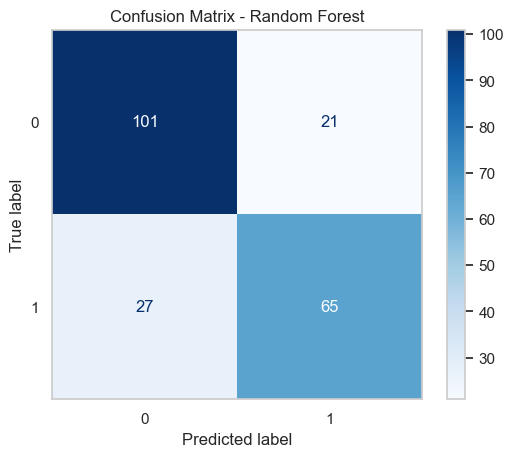

In [21]:
# Predict
y_pred = rf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

# assuming y_test and y_pred are already defined
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.show()

** Remarks **

- the model had a test accuracy of 78%. It showed slightly better performance in predicting non-survivors (Precision = 0.79, Recall = 0.83) than survivors (Precision = 0.76, Recall = 0.71). This slight imbalance suggests room for improvement in capturing patterns among the survivors, possibly through hyperparameter tuning, better feature engineering, or addressing class imbalance.

- note that this is higher than the simple percentron model, which had a accuracy of ~73%.


# 6 - Plotting feature importance

- we will plot the feature importances as calculated in the random forest model, through which we can definitely see which were the determining factor in survival

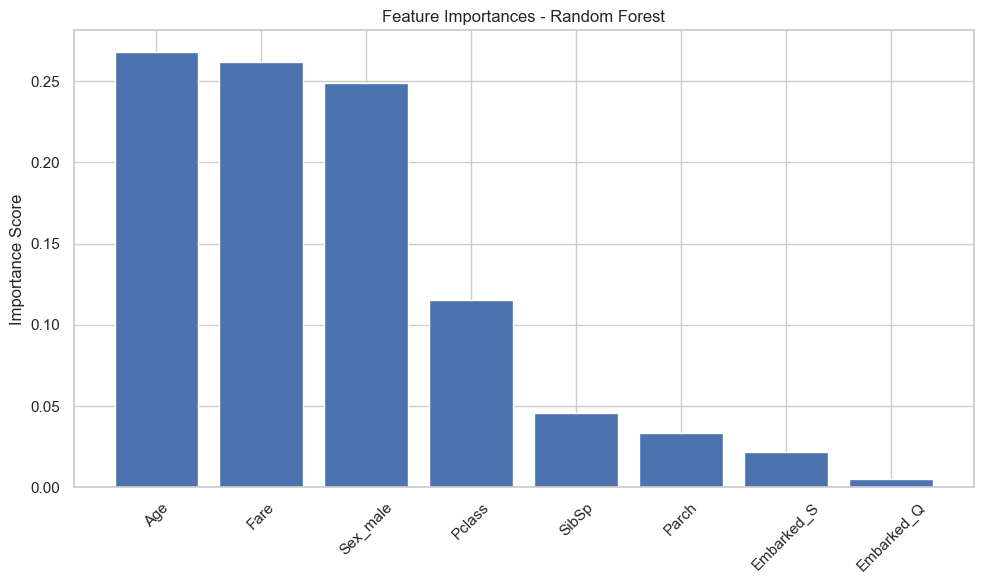

In [22]:
# Assuming you trained with X_train having column names
importances = rf.feature_importances_
feature_names = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.title("Feature Importances - Random Forest")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


** Remark **

- suprisingly, age was actually the top determining factor in survival, followed closely by Fare and Sex, each accounting for around 0.25 importance score. 

- other factors were not nearly as influential, with less than 0.05 importance scores. 

- this made me curious, does this mean we would obtain a more accurate model if we are to only include the top three influencial features?

- intuitively, it should be slightly better, but not by much. It will be slightly more accurate as noise is reduced through ommiting less important features, but since random forest benefit from having redundant features to improve generalization, it will not be a significant imporvement.  

# 7 - Train and output metrics and confusion matrix for truncated model

- here we will train and evaluate the truncated model with only the 3 most important features.

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       105
           1       0.77      0.69      0.73        74

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



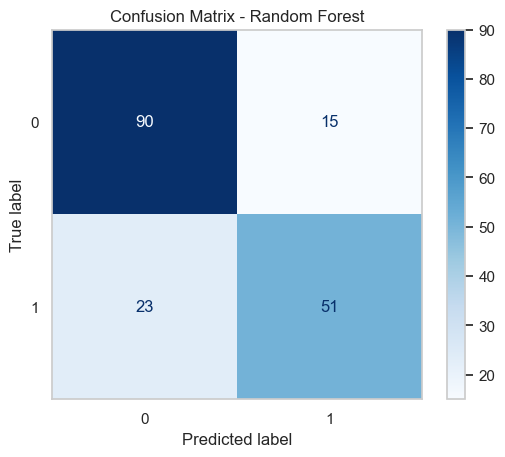

In [26]:
important_features = ['Age', 'Fare', 'Sex']

# Create dummy variables if needed (e.g., 'Sex')
X_important = pd.get_dummies(df[important_features], drop_first=True)
y = df['Survived']

# Train-test split, scaling, etc.
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_important, y, test_size=0.2, random_state=42)

# Train a new model
rf_important = RandomForestClassifier(random_state=42)
rf_important.fit(X_train_imp, y_train_imp)

# Evaluate
y_pred_imp = rf_important.predict(X_test_imp)
print(classification_report(y_test_imp, y_pred_imp))

# assuming y_test and y_pred are already defined
ConfusionMatrixDisplay.from_predictions(y_test_imp, y_pred_imp, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.show()

** Remarks **

- looks like our hypothesis was correct, the simplied model had an slighty higher accuracy of 0.79 (vs. 0.78 in the full model).

- Non-survivor accuracy of 0.8 and recall of 0.86 — the model correctly identified most non-survivors
- Survivor accuracy of 0.77, recall of 0.69, meaning it was less sensitive to survivors.

- looking at the confusion matrix, this model was slightly better at avoiding false negatives, with only 15 non-survivors labled as survivors(vs. 25)

### ✅ Conclusion

Using only the top 3 features yields a leaner model with comparable accuracy, making it a practical alternative when feature collection or processing cost is a concern. However, for applications where **sensitivity to survivors (recall for class 1)** is critical (e.g., in a medical or humanitarian context), the full model may still be preferable.



# Conclusion

- Our random forest model was adaquet at estimating survivorship abroad the Titanic using attributes such as class, fare, sex, etc. We were able to use all the attributes instead of just a few visually-seleccted ones, ensuring generalizability. 

- We also learned that using the most important features does not result in a much better model. It definitely streamlines the model by cutting out noise and reducing computation needed, but improvement in accuracy is minimal due to random forest being able to handle the non-important features to begin with.